In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
from collections import Counter
# Visualization
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from torchvision.transforms import ToTensor
from torchvision.models import resnet18,resnet50
from torch import nn
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

## For trained weights

In [4]:
from torchvision import models
original_model = models.resnet18(pretrained=True)
#original_model.g
#original_model=models.alexnet(pretrained=True)
class ResNetFashion(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = resnet18(num_classes=10)
        self.model.weight='IMAGENET1K_V1'
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.loss = nn.CrossEntropyLoss()
        self.features = nn.Sequential(
                        # stop at conv4   get_features()
                      torch.nn.Sequential(*list(self.model.children())[:-1])# *list(original_model.features.children())[:-1]
                    )

    @auto_move_data
    def forward(self, x):
        return self.model(x),self.model(x)#torch.softmax(model(x), dim=1)

    def training_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss
    def validation_step(self, batch, batch_no):
        x, y = batch
        #print(x.size())
        _,logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.005)#RMSprop

In [5]:
#orig_model = ResNetMNIST()
model = ResNetFashion()

In [6]:
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(
    save_dir='History',
    name='Fashoin_history'
)

In [7]:
trainer = pl.Trainer(
    #gpus=1,
    max_epochs=30,logger=[csv_logger],
    progress_bar_refresh_rate=20
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [8]:
import time
start_time = time.time()
if __name__ == "__main__":
    
    data_dir='./'
    # download
    FashionMNIST(data_dir, train=True, download=True)
    FashionMNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = FashionMNIST(data_dir,train=True,transform=transform)
    dataset_train = FashionMNIST(data_dir,train=True,transform=transform)
            
    #print(type(dataset_full),len(dataset_full)) 
    dataset_train, dataset_val,remaining = random_split(dataset_full, [60000,0,0])
    #print(len(dataset_train),type(dataset_train))
    dataset_train_original=copy.deepcopy(dataset_train)
    train_dl = DataLoader(dataset_train, batch_size=64, shuffle=True)
    #valid_dl = DataLoader(dataset_val, batch_size=64, shuffle=True)

    trainer.fit(model,train_dl)#,val_dataloaders=valid_dl)
Resnet_time = time.time() - start_time
print("--- %s seconds ---" % (time.time() - start_time))

C:\Users\USER\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)

  | Name     | Type             | Params
----------------------------------------------
0 | model    | ResNet           | 11.2 M
1 | loss     | CrossEntropyLoss | 0     
2 | features | Sequential       | 11.2 M
----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

--- 52359.950160741806 seconds ---


## Shows some of Fashion data

In [10]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

In [11]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=32)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

#plt.figure()
#for i in range(32):
#    plt.subplot(4,8,i+1)
#    arr=np.squeeze(data)
#    plt.imshow(my_sample[0][i][0], cmap='gray')
#    plt.axis('off')
#    plt.title(my_sample[1][i].item())

#dataloader = DataLoader(data, batch_size=32)

tensor([1, 5, 9, 8, 8, 4, 9, 6, 9, 0, 5, 7, 3, 2, 8, 9, 3, 3, 3, 0, 8, 8, 1, 9,
        1, 1, 9, 7, 6, 5, 8, 2])


## prepare_test_embeddings

In [12]:
def prepare_test_embeddings(dataset_train):
    #model=my_model
    transform = transforms.Compose([transforms.ToTensor()])
    data=dataset_train
    dataloader = DataLoader(data, batch_size=32)
    test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 10), dtype=torch.float32)
    #c=0
    #print(len(dataloader))
    for x,y in dataloader:
     #   print(c)
        #c=c+1
        x = x.cpu()
        embeddings, logits = model(x)#orig_model(x)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)
        test_predictions.extend(predicted_class.detach().cpu().tolist())
        test_targets.extend(y.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_embeddings = torch.cat((test_embeddings, embeddings), 0)
        test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
        #print('Y',y.detach().cpu().tolist())
    test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    #print(test_predictions == test_targets)
    test_acc = np.sum(test_predictions == test_targets)
    
    accuracy = accuracy_score(test_predictions, test_targets)#,average='micro')
    recall = recall_score(test_predictions, test_targets,average='micro')
    precision = precision_score(test_predictions, test_targets,average='micro')
    f1_score1 = f1_score(test_predictions, test_targets,average='micro')
    
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'precision: {precision*100:.2f}%')
    print(f'recall: {recall*100:.2f}%')
    print(f'f1_score1: {f1_score1*100:.2f}%')
    
    final_test_acc = test_acc/len(test_embeddings)
    
    return test_embeddings,test_targets,test_predictions,final_test_acc

In [13]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score,accuracy_score
# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score

In [14]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
test_embeddings,test_targets,test_predictions,final_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Accuracy: 91.24%
precision: 91.24%
recall: 91.24%
f1_score1: 91.24%
Initial Testing accuracy:   0.9124


In [15]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
#print(accuracy_score(test_targets,test_predictions, average='macro'))
c_matrix = metrics.confusion_matrix(test_targets,test_predictions)
print(metrics.classification_report(test_targets,test_predictions, digits=3))

              precision    recall  f1-score   support

           0      0.842     0.861     0.852      1000
           1      0.993     0.984     0.988      1000
           2      0.875     0.844     0.859      1000
           3      0.924     0.917     0.921      1000
           4      0.857     0.863     0.860      1000
           5      0.983     0.979     0.981      1000
           6      0.739     0.752     0.746      1000
           7      0.957     0.973     0.965      1000
           8      0.984     0.986     0.985      1000
           9      0.974     0.965     0.969      1000

    accuracy                          0.912     10000
   macro avg      0.913     0.912     0.913     10000
weighted avg      0.913     0.912     0.913     10000



In [18]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        sns.set(font_scale=1.5)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="cividis")#cividis
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Results\\FashionMNIST_confusion_matrix.png')

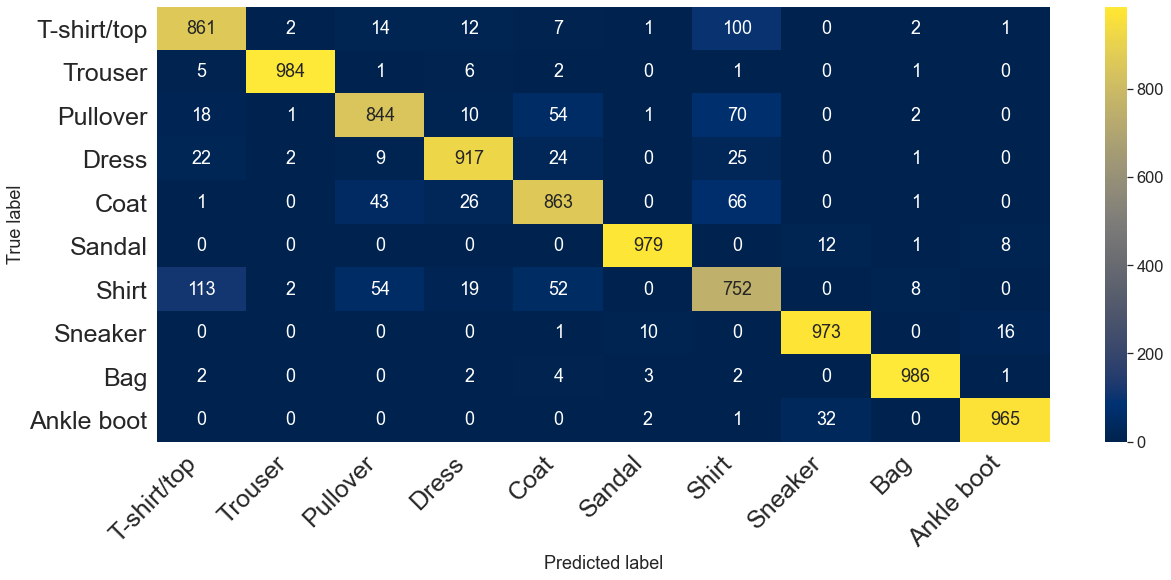

In [19]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
confusion_matrix(c_matrix, class_names, figsize = (20,8), fontsize=25)